In [31]:
import gymnasium as gym
import time
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

In [32]:

""" Tensorflow """
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [34]:
# Agent
def agent(state_shape, action_shape):
    """ observation -> q-values """
    learning_rate = 0.001

    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(24, input_shape=state_shape, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate==learning_rate), metrics=['accuracy'])
    
    return model

In [35]:
def reshape(obs):
    return obs.reshape([1, obs.shape[0]])

In [36]:
def train(model, target_model, replay_buffer):
    lr = 0.7
    gamma = 0.6
    X, Y = [], []

    if len(replay_buffer) < 1000:
        return
    
    batch_size = 64 * 2
    mini_batch = random.sample(replay_buffer, batch_size)
    observations = np.array([item[0] for item in mini_batch])
    new_observations = np.array([item[1] for item in mini_batch])

    # q = model.predict(reshape(observations)).flatten()
    # q_new = model.predict(reshape(new_observations)).flatten()
    qs = model.predict(observations)
    qs_new = target_model.predict(new_observations)     # only updated every episode

    """ Bellman equation to update q[action] """
    for index, (observation, new_observations, action, reward, done) in enumerate(mini_batch):
        if not done:
            max_q_new = reward + gamma * np.max(qs_new[index])
        else:
            max_q_new  = reward

        q = qs[index]
        q[action] = (1 - lr) * q[action] + lr * max_q_new

        X.append(observation)
        Y.append(q)

    """ Train model with updated q """
    model.fit(np.array(X),np.array(Y), batch_size=batch_size, verbose = 0, shuffle = True)
    # model.fit(reshape(observation), reshape(q))

In [37]:
def deep_q(env, model, target_model, reward_array, episodes):
    epsilon = 1  # probability of taking a random step 
    max_epsilon = 1
    min_epsilon = 0.01
    decay = 0.01

    replay_buffer = deque(maxlen=50_000)
    steps = 0

    for episode in range(0,episodes):
        score = 0
        terminated = False
        observation = env.reset()[0]

        while not terminated:
            steps += 1 
            # Exploration
            if np.random.uniform(0,1) < epsilon:
                # take random action
                action = env.action_space.sample()
            else:
                # get best known action from model
                action = np.argmax(model.predict(reshape(observation)))
                pass
            
            # Take step
            new_observation, reward, terminated, truncated, info  = env.step(action)
            replay_buffer.append([observation, new_observation, action, reward, terminated])
            score += reward
          
            #Update DQN
            if terminated or (steps % 4 == 0):
                # train DQN
                train(model, target_model, replay_buffer)
                    
            observation = new_observation
        
            # update target model
            if terminated and steps >= 100:
                print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps = 0

        # alter exploration
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
        reward_array.append(score)

        # print results
        print(episode+1, "/", episodes, "Episodes done, score:", score)
        print(steps, "survived steps")
        # End of the loop update
        # else:
        #     rewards += score
        #     reward_array.append(score)
            
        #     #print results
        #     #clear_output(wait=True)
        #     if score > 195 and steps >= 100: solved += 1
        #     print(episode, "/", episodes, "Episodes done,", str(np.round(solved/episode,4))+"% solved, score:", score)
        # if episode % timestep == 0: print(reward / timestep)

In [38]:
def test(env, model, reward_array, episodes):
    rewards, steps, solved = 0, 0, 0

    for episode in range(0,episodes):
        steps += 1 
      
        score = 0
        terminated, done = False, False
        observation = env.reset()[0]

        while not terminated:
            action = np.argmax(model.predict(reshape(observation)))
            
            # Take step
            new_observation, reward, terminated, truncated, info  = env.step(action)
            score+=reward
          
            observation = new_observation

# Training

In [39]:
train_env = gym.make("CartPole-v1")
train_env.reset()

# stats
# print(train_env.action_space) # 2 actions
# print(train_env.observation_space) # 4 states
# Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
# [x_min, vx_min, phi_min, vphi_min][x_max, vx_max, phi_max, vphi_max]

""" create agent """
# main model is used for predicitons
model = agent(train_env.observation_space.shape, train_env.action_space.n)

# target model is used for 'future' predictions
target_model = agent(train_env.observation_space.shape, train_env.action_space.n)
target_model.set_weights(model.get_weights())

### Training
reward_array = deque(maxlen=50000)
episodes = 1000

deep_q(train_env, model, target_model, reward_array, episodes)

train_env.close()

1 / 1000 Episodes done, score: 12.0
12 survived steps
2 / 1000 Episodes done, score: 11.0
23 survived steps
3 / 1000 Episodes done, score: 17.0
40 survived steps
4 / 1000 Episodes done, score: 15.0
55 survived steps
5 / 1000 Episodes done, score: 11.0
66 survived steps
1/1 [==============================] - 0s 34ms/step
6 / 1000 Episodes done, score: 15.0
81 survived steps
1/1 [==============================] - 0s 14ms/step


/Users/juri/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 14ms/step
Copying main network weights to the target network weights
7 / 1000 Episodes done, score: 76.0
0 survived steps
8 / 1000 Episodes done, score: 18.0
18 survived steps
1/1 [==============================] - 0s 14ms/step
9 / 1000 Episodes done, score: 18.0
36 survived steps
10 / 1000 Episodes done, score: 10.0
46 survived steps
11 / 1000 Episodes done, score: 12.0
58 survived steps
1/1 [==============================] - 0s 14ms/step
12 / 1000 Episodes done, score: 17.0
75 survived steps
1/1 [==============================] - 0s 13ms/step
13 / 1000 Episodes done, score: 13.0
88 survived steps
1/1 [==============================] - 0s 13ms/step
Copying main network weights to the target network weights
14 / 1000 Episodes done, score: 12.0
0 survived steps
1/1 [==============================] - 0s 14ms/step
15 / 1000 Episodes done, score: 10.0
10 survived steps
1/1 [==============================] - 0s 13ms/step
16 / 1000 Episodes done, sco

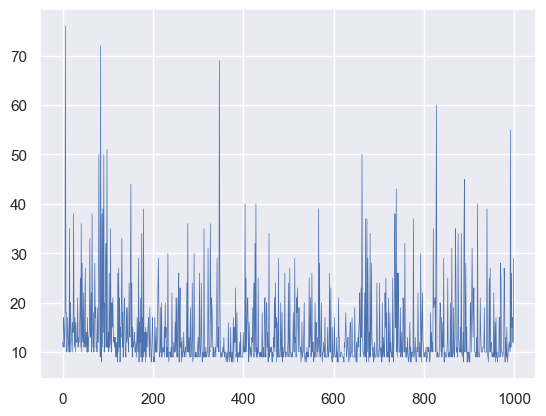

In [40]:
sns.set_theme()
plt.plot(reward_array, linewidth = 0.5)

# Testing

In [41]:
test_env = gym.make("CartPole-v1", render_mode="human")
test_env.reset()

episodes = 20
test(test_env, model, reward_array, episodes)

1/1 [==============================] - 0s 18ms/step


: 

In [ ]:
obs = train_env.reset()[0]
obs_r = reshape(obs)
oa = np.array([obs_r,obs_r])
print(oa)
print(model.predict(obs_r).flatten())
print(np.argmax((model.predict(obs_r).flatten())))

In [ ]:
train_env.reset()
action = train_env.action_space.sample()
obs, rew, ter, tr, d = train_env.step(action)
print(reshape(obs))
q = model.predict(reshape(obs))
print(q.flatten())
print(np.argmax(q))